In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
import pywren
import boto3
import pickle
import dill
from numpywren.matrix_utils import list_all_keys
import concurrent.futures as fs
import seaborn as sns
import numpywren.lambdapack as lp
from collections import defaultdict

In [18]:
def smooth(x,window_len=400,window='flat'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


In [19]:
#PROGRAM_ID = "1532144559"
#PROGRAM_ID = "1536687372"
PROGRAM_ID = "1556011548"
BUCKET = "numpywrentest"

## Load runtime data first
runtime data is data collected from redis perf counters giving aggregate performance information

In [20]:
s3_client = boto3.client("s3")

In [21]:
runtime_data = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key="{0}/{1}/runtime.pickle".format("lambdapack", PROGRAM_ID))["Body"].read())

In [22]:
print(runtime_data["program"].program)

### Here is a CDF of the total flops performed


In [23]:
runtime_data["writes"][-1]

6141.80323328

Text(0, 0.5, 'GFLOPS computed')

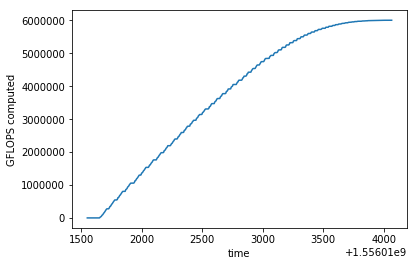

In [24]:
plt.plot(runtime_data["times"], runtime_data["flops"])
plt.xlabel("time")
plt.ylabel("GFLOPS computed")

### Here is a CDF of total bytes read 

Text(0, 0.5, 'GBytes read')

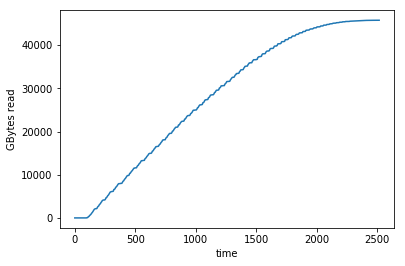

In [25]:
plt.plot(np.array(runtime_data["times"]) - np.array(runtime_data["times"][0]), (1e9*np.array(runtime_data["writes"])/((4096*4096*8))))
plt.xlabel("time")
plt.ylabel("GBytes read")

In [26]:
up_workers = np.array(runtime_data["up_workers"])
busy_workers = np.array(runtime_data["busy_workers"])/3
write_objects =  ((1e9*np.array(runtime_data["writes"]))/((4096*4096*8)))[:-1]
times = (np.array(runtime_data["times"][:-1]) - np.array(runtime_data["times"][0]))

In [27]:
np.min(up_workers)

146

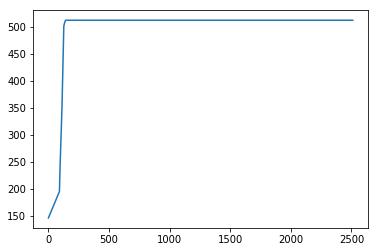

In [28]:
plt.plot(times, up_workers)

In [29]:
print(up_workers.shape)
print(times.shape)
print(busy_workers.shape)
print(write_objects.shape)

(482,)
(482,)
(482,)
(482,)


In [30]:
data = np.hstack((up_workers[:, np.newaxis], busy_workers[:, np.newaxis], write_objects[:, np.newaxis], times[:, np.newaxis]))

In [31]:
print(up_workers.shape)
print(write_objects.shape)
print(times.shape)


(482,)
(482,)
(482,)


In [32]:
import pandas as pd
csv_data = pd.DataFrame(data=data, columns=["lambdas", "busy_lambdas", "write_objects", "times"]).to_csv()

open("shiv_data_2.csv", "w+").write(csv_data)

24558

### Here is a CDF of total bytes written

Text(0, 0.5, 'GBytes write')

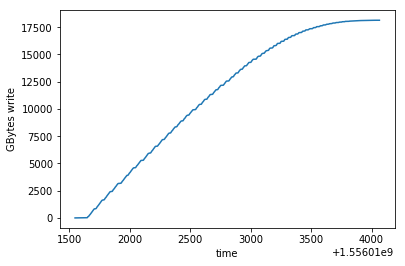

In [33]:
plt.plot(runtime_data["times"], runtime_data["reads"])
plt.xlabel("time")
plt.ylabel("GBytes write")

In [34]:
times = runtime_data["times"]

In [35]:
times

[1556011548.986455,
 1556011640,
 1556011645,
 1556011650,
 1556011655,
 1556011661,
 1556011666,
 1556011671,
 1556011676,
 1556011681,
 1556011686,
 1556011691,
 1556011696,
 1556011701,
 1556011706,
 1556011711,
 1556011716,
 1556011721,
 1556011726,
 1556011731,
 1556011736,
 1556011741,
 1556011746,
 1556011751,
 1556011756,
 1556011761,
 1556011766,
 1556011771,
 1556011776,
 1556011781,
 1556011787,
 1556011792,
 1556011797,
 1556011802,
 1556011807,
 1556011812,
 1556011817,
 1556011822,
 1556011827,
 1556011832,
 1556011837,
 1556011842,
 1556011847,
 1556011852,
 1556011857,
 1556011862,
 1556011867,
 1556011872,
 1556011877,
 1556011882,
 1556011887,
 1556011892,
 1556011897,
 1556011902,
 1556011907,
 1556011912,
 1556011918,
 1556011923,
 1556011928,
 1556011933,
 1556011938,
 1556011943,
 1556011948,
 1556011953,
 1556011958,
 1556011963,
 1556011968,
 1556011973,
 1556011978,
 1556011983,
 1556011988,
 1556011993,
 1556011998,
 1556012003,
 1556012008,
 1556012013,
 1556

In [36]:
np.mean(np.gradient(runtime_data["times"])[100:])

5.04177545691906

In [37]:
times[-1] - times[0]

2516.013545036316

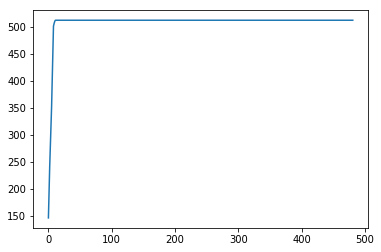

In [38]:
plt.plot(runtime_data["up_workers"])

Text(0, 0.5, 'TFLOP/s Rate')

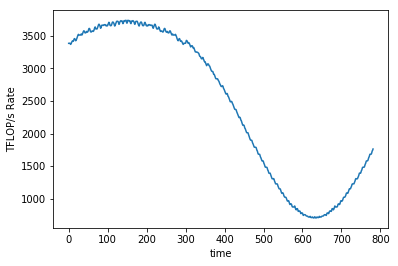

In [39]:
#plt.plot(smooth(np.gradient(runtime_data["writes"])/np.gradient(runtime_data["times"][:-1]), window_len=1), label="smoothed")
plt.plot(smooth(np.gradient(runtime_data["flops"])/np.gradient(runtime_data["times"]), window_len=300), label="smoothed")
#plt.plot(smooth(np.array(times[:-1]), window_len=1), smooth(np.gradient(runtime_data["writes"]), window_len=1), label="raw")
plt.xlabel("time")
plt.ylabel("TFLOP/s Rate")
#plt.title("ramping up to 20K workers")


In [53]:
eruntime_data["flops"][-1] - runtime_data["flops"][0]

26446676.02567168

Text(0.5, 1.0, 'ramping up to 20K workers')

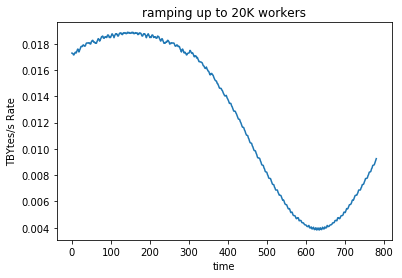

In [40]:
plt.plot(smooth(np.gradient(runtime_data["writes"])/1000, window_len=300), label="smooth with window len of 300")
plt.xlabel("time")
plt.ylabel("TBYtes/s Rate")
plt.title("ramping up to 20K workers")

In [55]:
(runtime_data["times"][-1] - runtime_data["times"][-100])

133

In [56]:
(runtime_data["writes"][-1] - runtime_data["writes"][-100])/(runtime_data["times"][-1] - runtime_data["times"][-100])

50.09752384288723

In [28]:
np.mean(smooth(np.gradient(runtime_data["writes"])/1000)

SyntaxError: unexpected EOF while parsing (<ipython-input-28-ac44858f51b3>, line 1)

### There is a lot more information in the runtime data dictionary

In [41]:
read_txns_cdf = (1e9*np.array(runtime_data["reads"])/(4096*4096*8)).astype('int')
write_txns_cdf = (1e9*np.array(runtime_data["writes"])/(4096*4096*8)).astype('int')
times = runtime_data["times"]



In [312]:
reads = runtime_data["reads"]
flops = runtime_data["flops"]
writes = runtime_data["writes"]

In [57]:
runtime_data[]

dict_keys(['redis_done_counts', 'redis_ready_counts', 'redis_post_op_counts', 'redis_not_ready_counts', 'redis_running_counts', 'sqs_invis_counts', 'sqs_vis_counts', 'busy_workers', 'up_workers', 'times', 'lru', 'priority', 'eager', 'truncate', 'max_cores', 'problem_size', 'shard_size', 'pipeline', 'flops', 'reads', 'writes', 'read_objects', 'write_objects', 'trial', 'launch_granularity', 'log_granularity', 'autoscale_policy', 'standalone', 'program', 'time_steps', 'failed', 'all_futures'])

In [349]:
times_peak = runtime_data["times"][-1000:]

In [354]:
times_peak[-1] - times_peak[0]

1761

In [313]:
np.mean(np.gradient(reads[-1000:])) * 4

2905.7273749831684

## All the information below is low level per operation program tracing 
(we could potentially subsample the number of operations to speed this up but as this stands the serial runtime of 
the below cells is n^3/b^3). Currently all the s3 keys are downloaded  locally but this could be sped up and parallelized using pywren (or we could just let this run over night)

In [42]:
#TODO: EJ when keyspace is large you probably don't want to do this centrally?
lst = [x for x in list_all_keys(bucket=BUCKET, prefix="{0}/{1}".format("lambdapack", PROGRAM_ID)) if "runtime" not in x]

In [44]:
list_all_keys(bucket=BUCKET, prefix="{0}/{1}".format("lambdapack", PROGRAM_ID))

['lambdapack/1556011548/runtime.pickle']

In [17]:
def download_profiled_block(key, bucket):
    client = boto3.client('s3')
    return dill.loads(client.get_object(Key=key, Bucket=bucket)["Body"].read())


def perf_profile(blocks, num_bins=100):
    READ_INSTRUCTIONS = [lp.OC.S3_LOAD]
    WRITE_INSTRUCTIONS = [lp.OC.S3_WRITE, lp.OC.RET]
    COMPUTE_INSTRUCTIONS = [lp.OC.GENERIC]
    # first flatten into a single instruction list
    instructions_full = [inst for block in blocks for inst in block.instrs]
    instructions = [inst for block in blocks for inst in block.instrs if inst.end_time != None and inst.start_time != None]
    start_times = [inst.start_time for inst in instructions]
    end_times = [inst.end_time for inst in instructions]

    abs_start = min(start_times)
    last_end = max(end_times)
    tot_time = (last_end - abs_start)
    bins = np.linspace(0, tot_time, tot_time)
    total_flops_per_sec = np.zeros(len(bins))
    read_bytes_per_sec = np.zeros(len(bins))
    write_bytes_per_sec = np.zeros(len(bins))
    read_txns = np.zeros(len(bins))
    write_txns = np.zeros(len(bins))
    runtimes = []

    for i,inst in enumerate(instructions):
        if (inst.end_time == None or inst.start_time == None):
          # replay instructions don't always have profiling information...
          continue
        duration = inst.end_time - inst.start_time
        if (inst.i_code in READ_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            size = inst.size
            bytes_per_sec = size/duration
            gb_per_sec = bytes_per_sec/1e9
            read_bytes_per_sec[start_bin:end_bin]  += gb_per_sec
            read_txns[start_bin:end_bin] += 1/duration

        if (inst.i_code in WRITE_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            size = inst.size
            bytes_per_sec = size/duration
            gb_per_sec = bytes_per_sec/1e9
            write_bytes_per_sec[start_bin:end_bin]  += gb_per_sec
            write_txns[start_bin:end_bin] += 1/duration

        if (False and inst.i_code in COMPUTE_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            flops = inst.flops
            flops_per_sec = flops/duration
            gf_per_sec = flops_per_sec/1e9
            total_flops_per_sec[start_bin:end_bin]  += gf_per_sec
        runtimes.append(duration)
    optimes = defaultdict(int)
    opcounts = defaultdict(int)
    computetimes = defaultdict(int)
    computecounts = defaultdict(int)
    offset = instructions[0].start_time
    for inst, t in zip(instructions, runtimes):
      opcounts[inst.i_code] += 1
      optimes[inst.i_code] += t
      if (inst.i_code in COMPUTE_INSTRUCTIONS):
        computetimes[inst.compute] += t
        computecounts[inst.compute] += 1
      IO_INSTRUCTIONS = [lp.OC.S3_LOAD, lp.OC.S3_WRITE, lp.OC.RET]
    print("Average instruction runtimes:")
    for k in optimes.keys():
      print("{0}: {1}s".format(k, optimes[k]/opcounts[k]))
    print("Average Compute runtimes:")
    for k in computetimes.keys():
      print("{0}: {1}s".format(k, computetimes[k]/computecounts[k]))
    return read_txns, write_txns, read_bytes_per_sec, write_bytes_per_sec, total_flops_per_sec, bins , instructions, runtimes



 

In [31]:
f = runtime_data['all_futures']

In [34]:
f[0].result()

KeyboardInterrupt: 

In [18]:
 
executor = fs.ThreadPoolExecutor(64)
futures = []
for key in lst:
    futures.append(executor.submit(download_profiled_block, key, BUCKET))
    
print(len(futures))
res = fs.wait(futures)


profiled_blocks = []
for f in futures:
    try:
        profiled_blocks.append(f.result())
    except:
        pass

578


In [1]:
profiled_blocks_flat = [pickle.loads(b) for x in profiled_blocks for b in x.values()]

NameError: name 'profiled_blocks' is not defined

In [20]:
profiled_blocks_flat[0]

In [21]:

len(profiled_blocks)


577

In [22]:
len(profiled_blocks_flat)

22349

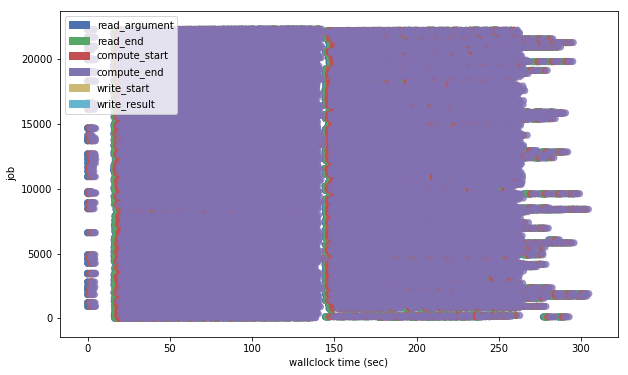

In [23]:
from matplotlib import patches as mpatches
time_offset = np.min([i.start_time for b in profiled_blocks_flat for i in b.instrs if i.start_time != None and i.end_time != None])
instructions = [i for b in profiled_blocks_flat for i in b.instrs if i.start_time != None and i.end_time != None]
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
total_jobs = len(instructions)
y = np.arange(len(instructions))
point_size = 50

start_times = np.array([i.start_time for i in instructions]) - time_offset
end_times = np.array([i.end_time for i in instructions]) - time_offset
palette = sns.color_palette("deep", 6)
patches = []

READ_INSTRUCTIONS = [lp.OC.S3_LOAD]
WRITE_INSTRUCTIONS = [lp.OC.S3_WRITE]
COMPUTE_INSTRUCTIONS = [lp.OC.GENERIC]

read_starts = []
read_ends = []
write_starts = []
write_ends = []
compute_starts = []
compute_ends = []
read_ys = []
write_ys = []
compute_ys = []
write_times = []
compute_times = []
read_times = []
for j,block in enumerate(profiled_blocks_flat):
    syrk = False
    for i in block.instrs:
        if i.start_time == None or i.end_time == None: 
            continue
        if (i.i_code in READ_INSTRUCTIONS):
            read_starts.append(i.start_time - time_offset)
            read_ends.append(i.end_time - time_offset)
            read_times.append(i.end_time - i.start_time)
            read_ys.append(j) 
            
        elif (i.i_code in COMPUTE_INSTRUCTIONS):
            compute_starts.append(i.start_time - time_offset)
            compute_ends.append(i.end_time - time_offset)
            compute_times.append(i.end_time - i.start_time)
            compute_ys.append(j)
        elif (i.i_code in WRITE_INSTRUCTIONS):
            
            if (syrk):
                write_starts.append(i.start_time - time_offset)
                write_ends.append(i.end_time - time_offset)
                write_times.append(write_ends[-1] - write_starts[-1])
                write_ys.append(j)
       

ax.scatter(read_starts, read_ys,  c=palette[0], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[0], label="read_argument"))
ax.scatter(read_ends, read_ys,  c=palette[1], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[1], label="read_end"))

ax.scatter(compute_starts, compute_ys,  c=palette[2], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[2], label="compute_start"))
ax.scatter(compute_ends, compute_ys,  c=palette[3], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[3], label="compute_end"))

ax.scatter(write_starts, write_ys,  c=palette[4], edgecolor='none', s=point_size, alpha=0.2)
patches.append(mpatches.Patch(color=palette[4], label="write_start"))
ax.scatter(write_ends, write_ys,  c=palette[5], edgecolor='none', s=point_size, alpha=0.2)
patches.append(mpatches.Patch(color=palette[5], label="write_result"))
ax.set_xlabel('wallclock time (sec)')
ax.set_ylabel('job')

legend = pylab.legend(handles=patches, 
                      loc='upper left', frameon=True)
legend.get_frame().set_facecolor('#FFFFFF')

In [27]:
futures[0]

<Future at 0x7f013df98e10 state=finished returned dict>

In [25]:
%time read_txns, write_txns, read,write,total_flops,bins, instructions, runtimes = perf_profile(profiled_blocks_flat, num_bins=100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Average instruction runtimes:
RemoteInstructionOpCodes.S3_LOAD: 1.033746175140243s
RemoteInstructionOpCodes.GENERIC: 2.0684284900273724s
RemoteInstructionOpCodes.S3_WRITE: 1.537536223651825s
Average Compute runtimes:
<function qr_leaf at 0x7f014b31c598>: 2.0886806294644678s
<function qr_trailing_update at 0x7f014b31c840>: 2.030294497956773s
<function qr_factor at 0x7f014b31c400>: 1.597846439906529s
CPU times: user 1.46 s, sys: 380 ms, total: 1.84 s
Wall time: 1.41 s


In [61]:
compute_times = [y - x for x,y in zip(compute_starts, compute_ends)]

In [103]:
write_times > 

50.5872351307873

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


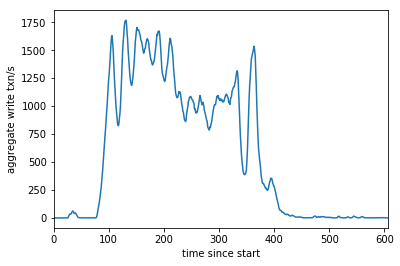

In [50]:
sns.tsplot(write_txns, time=(bins - min(bins)))
plt.xlabel("time since start")
plt.ylabel("aggregate write txn/s")
plt.savefig("20k_write_txns.pdf")
#plt.xlim(10,12)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


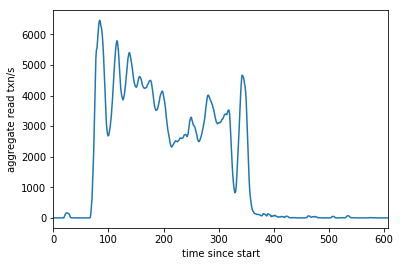

In [51]:
sns.tsplot(read_txns, time=(bins - min(bins)))
plt.xlabel("time since start")
plt.ylabel("aggregate read txn/s")
plt.savefig("20k_read_txns.pdf")
#plt.xlim(10,12)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


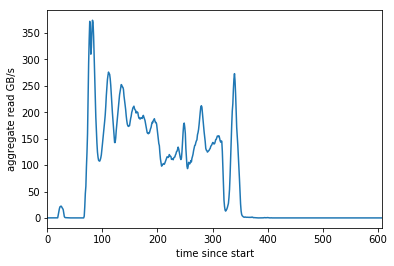

In [52]:
sns.tsplot(read, time=(bins - min(bins)))
plt.xlabel("time since start")
plt.ylabel("aggregate read GB/s")
plt.savefig("20k_read_bw.pdf")
#plt.xlim(10,12)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


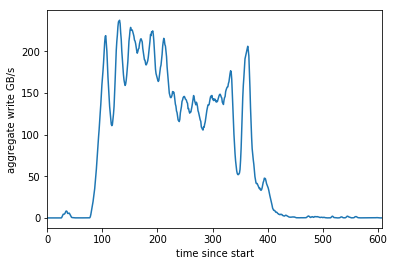

In [54]:
sns.tsplot((write), time=(bins - min(bins)))
plt.xlabel("time since start")
plt.ylabel("aggregate write GB/s")
plt.savefig("20k_write_bw.pdf")


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


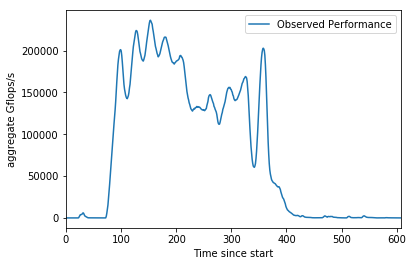

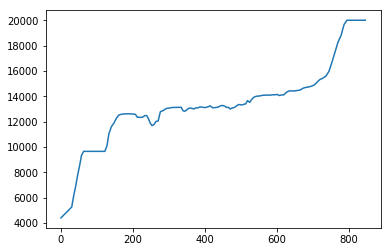

In [55]:
sns.tsplot(total_flops, time=(bins - min(bins)), condition="Observed Performance")
plt.xlabel("Time since start")
plt.ylabel("aggregate Gflops/s")
plt.savefig("20k_flops.pdf",  bbox_inches="tight")
plt.figure()
plt.plot(times, np.minimum(up_workers, 2e4))

In [54]:
import dill

In [55]:

with open("profiled_blocks_20k.pickle", "wb+") as f:
    f.write(dill.dumps(profiled_blocks))

In [61]:
max(total_flops)

254298.54908288742

In [79]:
logfile = open("08_26_20k_job.log").read()

In [143]:
up_workers = []
times = []
times_read = []
read_timeouts = []
write_timeouts = []
times_write = []
write_times = []

for line in logfile.split("\n"):
    if "Up Workers" in line:
        try:
            times.append(int(line.split(",")[0].split(":")[0]))
            up_workers.append(int(line.split(",")[0].split(":")[-1]))
        except:
            pass
    if "Read timeouts" in line and "fraction" not in line:
        try:
            #print(line.split(",")[0].split(":")[-1])
            times_read.append(int(line.split(",")[0].split(":")[0]))
            read_timeouts.append(int(line.split(",")[0].split(":")[-1]))
        except:
            pass
    if "Write timeouts" in line and "fraction" not in line:
        try:
            #print(line.split(",")[0].split(":")[-1])
            #print(line)
            times_write.append(int(line.split(",")[0].split(":")[0]))
            write_timeouts.append(int(line.split(",")[1].split(":")[-1]))
            #print(write_timeouts[-1])
        except:
            pass
        

In [137]:
up_workers = np.array(up_workers)

In [129]:
times = np.array(times)

Text(0,0.5,'number of workers killed by PyWren')

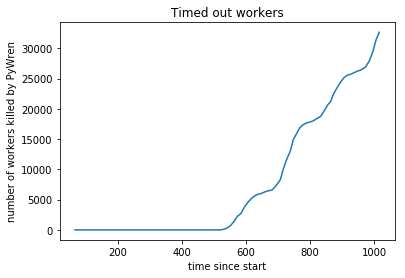

In [130]:
plt.title("Timed out workers")
plt.plot(times,np.maximum(up_workers - 20000, 0))
plt.xlabel("time since start")
plt.ylabel("number of workers killed by PyWren")

In [131]:
np.maximum(up_workers - 20000, 0).shape

(105,)

Text(0,0.5,'Number of S3 timeouts')

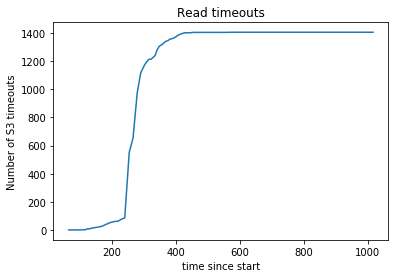

In [145]:
plt.title("Read timeouts")
plt.plot(times_read, read_timeouts)
plt.xlabel("time since start")
plt.ylabel("Number of S3 timeouts")

Text(0,0.5,'Number of S3 timeouts')

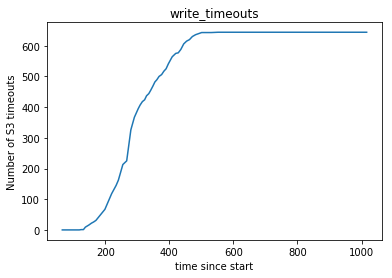

In [144]:
plt.title("write_timeouts")
plt.plot(times_write, write_timeouts)
plt.xlabel("time since start")
plt.ylabel("Number of S3 timeouts")